I used the Short Run Simple Moving Average (SMA) and Long Run SMA in order to algorithmically develop buy and sell signals for Facebook and Microsoft 
stocks the same 11 month time period. 

SMAs are useful in identify the general trend of the stock's price but can take some time to adjust to trends as every value in the average is given equal weightage. 

Buy when short run SMA is above the long run SMA and sell when the short run SMA crosses is below the long run SMA.

In [1]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
import yfinance
from datetime import date

In [2]:
fb_stock = yfinance.download('FB', start='2020-04-12', end='2021-06-29', interval='1d')
msft_stock = yfinance.download('MSFT', start='2020-04-12', end='2021-06-29', interval='1d')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


The data collected from the yfinance API contains frequent gaps between certain days. While this had minimal effect on the RSI analysis, this caused visible delays between when a pattern was identified and the appropriate trade signal was predicted. The reliability of the trade signals was improved by filling the missing dates in the data set.  

In [3]:
idx = pd.date_range('2020-04-12', '2021-06-29')
fb_stock = fb_stock.reindex(idx, fill_value=np.nan)
msft_stock = msft_stock.reindex(idx, fill_value=np.nan)
fb_stock['Adj Close'] = fb_stock['Adj Close'].ffill().bfill()
msft_stock['Adj Close'] = msft_stock['Adj Close'].ffill().bfill()

The starting date for gathering the stock data was experimentally determined in order to have a valid 100 day SMA for the first date July 20th, 2020. This helps in standarizing the various technical indicators. 

In [4]:
fb_stock.iloc[99]

Open         2.400600e+02
High         2.460500e+02
Low          2.356400e+02
Close        2.454200e+02
Adj Close    2.454200e+02
Volume       2.087220e+07
Name: 2020-07-20 00:00:00, dtype: float64

While different time intervals can be used for the short run SMA and long run SMA, the 25 day short run SMA and the 100 day long run SMA provides a good balance for this data set. Normally, the 50d SMA and 200d SMA work well, but the market is recovering from the covid pandemic. Therefore, the 200d sma is not ideal in this scenario. 

In [5]:
fb_stock['25d sma'] = fb_stock['Adj Close'].rolling(window=25).mean()
fb_stock['100d sma'] = fb_stock['Adj Close'].rolling(window=100).mean()
msft_stock['25d sma'] = msft_stock['Adj Close'].rolling(window=25).mean()
msft_stock['100d sma'] = msft_stock['Adj Close'].rolling(window=100).mean()

In [6]:
fb_stock = fb_stock.dropna()
msft_stock = msft_stock.dropna()

In [7]:
def buy_sell_indicators(df):
    buy_points = []
    sell_points = []
    stock_status = 0
    transaction_history = []
    transaction_history_price = []
    profit = 0
    for index in range(0, len(df)):
        if stock_status != 1 and df['25d sma'][index] > df['100d sma'][index]: 
            buy_points.append(df['Adj Close'][index])
            sell_points.append(np.nan)
            profit -= df['Adj Close'][index]
            transaction_history.append('Buy') 
            transaction_history_price.append(df['Adj Close'][index])
            stock_status = 1
        elif stock_status != 0 and stock_status != 2 and df['25d sma'][index] < df['100d sma'][index]:
            buy_points.append(np.nan)
            sell_points.append(df['Adj Close'][index])
            profit += df['Adj Close'][index]
            transaction_history.append('Sell') 
            transaction_history_price.append(df['Adj Close'][index])
            stock_status = 2
        else:
            buy_points.append(np.nan)
            sell_points.append(np.nan)
    if transaction_history.count('Buy') > transaction_history.count('Sell'):
        profit += transaction_history_price[-1]
    return buy_points, sell_points, profit

In [8]:
fb_stock['Buy'] = buy_sell_indicators(fb_stock)[0]
fb_stock['Sell'] = buy_sell_indicators(fb_stock)[1]
fb_stock_profit = buy_sell_indicators(fb_stock)[2]
msft_stock['Buy'] = buy_sell_indicators(msft_stock)[0]
msft_stock['Sell'] = buy_sell_indicators(msft_stock)[1]
msft_stock_profit = buy_sell_indicators(msft_stock)[2]

In [9]:
fb_stock.head(5)

,Open,High,Low,Close,Adj Close,Volume,25d sma,100d sma,Buy,Sell
2020-07-20,240.059998,246.050003,235.639999,245.419998,245.419998,20872200.0,236.122401,219.521201,245.419998,NaN
2020-07-21,246.220001,246.910004,240.080002,241.750000,241.750000,19364200.0,237.149200,220.190801,NaN,NaN
2020-07-22,240.259995,241.899994,238.119995,239.869995,239.869995,15427900.0,238.100800,220.841601,NaN,NaN
2020-07-23,239.630005,242.419998,231.750000,232.600006,232.600006,21771800.0,238.761600,221.385901,NaN,NaN
2020-07-24,230.190002,233.490005,226.899994,230.710007,230.710007,18325800.0,239.164401,221.923301,NaN,NaN


In [10]:
msft_stock.head(5)

,Open,High,Low,Close,Adj Close,Volume,25d sma,100d sma,Buy,Sell
2020-07-20,205.000000,212.300003,203.009995,211.600006,209.570831,36884800.0,204.238841,186.871169,209.570831,NaN
2020-07-21,213.660004,213.940002,208.029999,208.750000,206.748154,37990400.0,204.730878,187.303975,NaN,NaN
2020-07-22,209.199997,212.300003,208.389999,211.750000,209.719360,49605700.0,205.341763,187.766494,NaN,NaN
2020-07-23,207.190002,210.919998,202.149994,202.539993,200.597687,67457000.0,205.587781,188.056906,NaN,NaN
2020-07-24,200.419998,202.860001,197.509995,201.300003,199.369598,39827000.0,205.701084,188.353013,NaN,NaN


In [11]:
print('The Facebook stock earned a profit of ' + '${:,.2f}'.format(fb_stock_profit) + ' using the SMA')
print('The Microsoft stock earned a profit of ' + '${:,.2f}'.format(msft_stock_profit) + ' using the SMA')

The Facebook stock earned a profit of $15.46 using the SMA
The Microsoft stock earned a profit of $-1.64 using the SMA


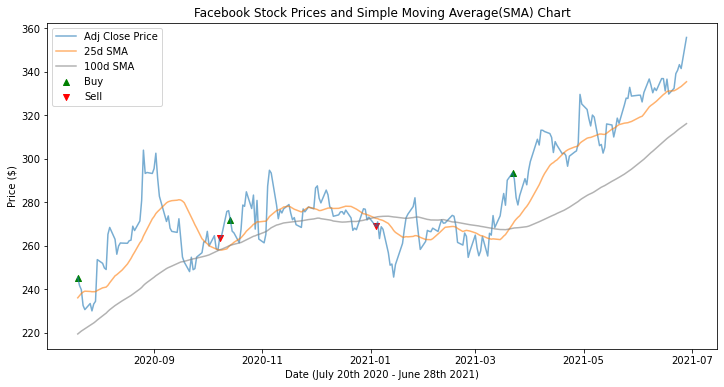

In [12]:
plt.figure(figsize=(12, 6))
plt.title('Facebook Stock Prices and Simple Moving Average(SMA) Chart')
plt.plot(fb_stock.index, fb_stock['Adj Close'], alpha=0.6)
plt.plot(fb_stock.index, fb_stock['25d sma'], alpha=0.6)
plt.plot(fb_stock.index, fb_stock['100d sma'], alpha=0.6, color='grey')
plt.scatter(fb_stock.index, fb_stock['Buy'], color='green', marker='^')
plt.scatter(fb_stock.index, fb_stock['Sell'], color='red', marker='v')
plt.legend(['Adj Close Price', '25d SMA', '100d SMA', 'Buy', 'Sell'], loc='upper left')
plt.xlabel('Date (July 20th 2020 - June 28th 2021)')
plt.ylabel('Price ($)')
plt.show()

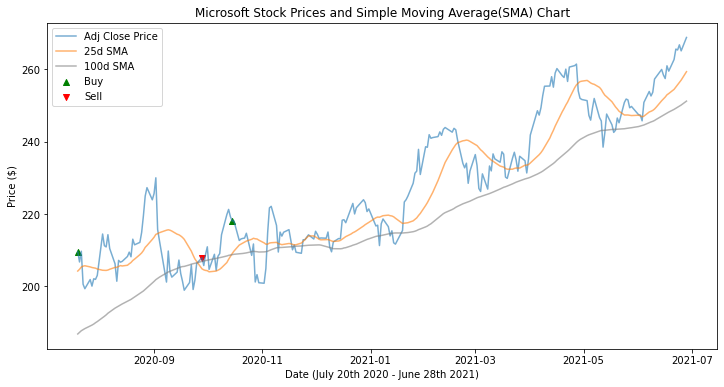

In [13]:
plt.figure(figsize=(12, 6))
plt.title('Microsoft Stock Prices and Simple Moving Average(SMA) Chart')
plt.plot(msft_stock.index, msft_stock['Adj Close'], alpha=0.6)
plt.plot(msft_stock.index, msft_stock['25d sma'], alpha=0.6)
plt.plot(msft_stock.index, msft_stock['100d sma'], color='grey', alpha=0.6)
plt.scatter(msft_stock.index, msft_stock['Buy'], color='green', marker='^')
plt.scatter(msft_stock.index, msft_stock['Sell'], color='red', marker='v')
plt.legend(['Adj Close Price', '25d SMA', '100d SMA', 'Buy', 'Sell'], loc='upper left')
plt.xlabel('Date (July 20th 2020 - June 28th 2021)')
plt.ylabel('Price ($)')
plt.show()